<a href="https://colab.research.google.com/github/NicholayKurbatov/DLS_1sem/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B8%CC%86%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.%20Telegram%20Bot/NST_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 53ddecf5d0350f715a8f6a5e28e338ab3b8691ef

#Imports & loads

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models
import requests
from IPython.display import clear_output
%matplotlib inline

In [3]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
backbone = models.vgg19(pretrained=True).features.to(device).eval().requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [5]:
for (i, layer) in enumerate(backbone):
  if isinstance(layer, torch.nn.MaxPool2d):
    backbone[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

#Image load

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def load_image(url_img, max_size=256, shape=None):
    
    image = requests.get(url_img).content
    with open('/content/image_name.jpg', 'wb') as handler:
        handler.write(image)
    image = Image.open('/content/image_name.jpg').convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [8]:
# content im.
content = load_image('https://w-dog.ru/wallpapers/2/2/549185023775360/yug-germanii-yugo-zapadnaya-bavariya-zamok-nojshvanshtajn-osen-gory.jpg').to(device)
# styles im., resize style to content
style_1 = load_image('https://img2.goodfon.ru/original/1920x1408/0/aa/kartina-zvezdnaya-noch-van-goga.jpg',
                     shape=content.shape[-2:]).to(device)
#'https://telegra.ph/file/cb442889243e5e96cb73f.jpg'
style_2 = load_image('https://i.pinimg.com/originals/b9/90/a2/b990a2d645291b40577a7315683b61df.png',
                     shape=content.shape[-2:]).to(device)

In [9]:
# convert tesnor to image, denormalize
def im_convert(tensor):
  # tensor.detach() creates a tensor that shares storage with tensor that does not require grad. 
  # It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0) # to -> H, W, C
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
  image = image.clip(0, 1)
  return image

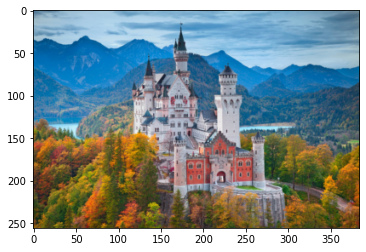

In [10]:
plt.imshow(im_convert(content))

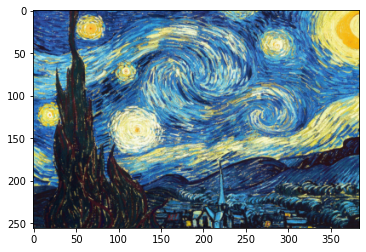

In [11]:
plt.imshow(im_convert(style_1))

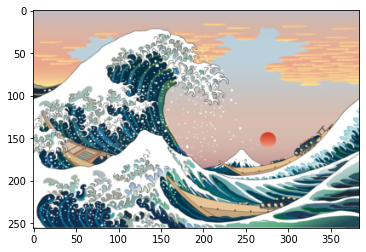

In [12]:
plt.imshow(im_convert(style_2))

#Net building and Training

In [13]:
def gram_matrix(tensor):
    batch_size, channels, height, width = tensor.size()
    
    tensor = tensor.view(batch_size * channels, height * width)
    gram = tensor @ tensor.t()
    
    return gram

In [14]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content layer
                  '28': 'conv5_1'}
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [15]:
content_features = get_features(content, backbone)
style_1_features = get_features(style_1, backbone)
style_2_features = get_features(style_2, backbone)

In [17]:
style_1_grams = {layer: gram_matrix(style_1_features[layer]) for layer in style_1_features}
style_2_grams = {layer: gram_matrix(style_2_features[layer]) for layer in style_2_features}

In [18]:
target = content.clone().requires_grad_(True).to(device)

In [19]:
style_1_weights = {'conv1_1': 0.1,
                  'conv2_1': 0.2,
                  'conv3_1': 0.2,
                  'conv4_1': 0.5,
                  'conv5_1': 0.75}

style_2_weights = {'conv1_1': 0.1,
                  'conv2_1': 0.2,
                  'conv3_1': 0.2,
                  'conv4_1': 0.5,
                  'conv5_1': 0.75}

content_weight = 1 
style_1_weight = 1e5
style_2_weight = 1e5

#Train loop for two styles on different parts

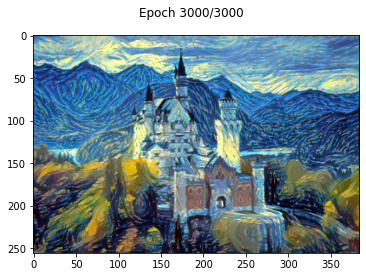

In [20]:
show_every = 200
optimizer = optim.AdamW([target], lr=3e-3)
num_epochs = 3000

for ii in range(1, num_epochs+1):
    
    target_features = get_features(target, backbone)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_1_loss = 0

    for layer in style_1_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_1_gram = style_1_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_1_loss = style_1_weights[layer] * torch.mean((target_gram - style_1_gram)**2)
        # add to the style loss
        style_1_loss += layer_style_1_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_1_weight * style_1_loss 
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        clear_output()
        plt.imshow(im_convert(target))
        plt.suptitle('Epoch %d/%d'%(ii, num_epochs))
        plt.show()